In [1]:
import pathlib
import os
import glob
from collections.abc import Iterable, Iterator
from typing import Tuple, List

import numpy as np
import polars as pl
import SimpleITK as sitk
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

project_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/Intervertebral-discs-degeneration-grade-classification-according-to-the-Pfirrmann-scale/")
data_path = project_path.joinpath("data/SPIDER_kaggle/")
images_path = data_path.joinpath("images/images/")
masks_path = data_path.joinpath("masks/masks/")

## Data Loading and Train/Val/Test Split

We are getting all T2 images and corresponding masks, then split by patient into train (70%), validation (15%), and test (15%) sets.

In [ ]:
def get_t2_file_pairs():
    """Get all T2 image and mask file pairs."""
    t2_files = []
    
    for img_file in sorted(images_path.glob("*_t2.mha")):
        patient_id = img_file.stem.replace("_t2", "")
        mask_file = masks_path / f"{patient_id}_t2.mha"
        
        if mask_file.exists():
            t2_files.append({
                "patient_id": int(patient_id),
                "image_path": img_file,
                "mask_path": mask_file
            })
        else:
            print(f"Warning: No mask found for {img_file.name}")
    
    return t2_files

t2_file_pairs = get_t2_file_pairs()
print(f"Found {len(t2_file_pairs)} T2 image/mask pairs")
print(f"Patient IDs: {[p['patient_id'] for p in t2_file_pairs[:10]]}... (showing first 10)")

Found 210 T2 image/mask pairs
Patient IDs: [100, 101, 104, 105, 106, 107, 108, 109, 10, 110]... (showing first 10)


In [ ]:
def split_data_by_patient(file_pairs, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split file pairs by patient to ensure no patient appears in multiple sets.
    """
    patient_ids = list(set(p["patient_id"] for p in file_pairs))
    print(f"Total unique patients: {len(patient_ids)}")
    
    # train + the rest
    train_patients, temp_patients = train_test_split(
        patient_ids, 
        train_size=train_ratio, 
        random_state=random_state
    )
    
    # the rest into val and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_patients, test_patients = train_test_split(
        temp_patients, 
        train_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    train_set = set(train_patients)
    val_set = set(val_patients)
    test_set = set(test_patients)
    
    train_files = [p for p in file_pairs if p["patient_id"] in train_set]
    val_files = [p for p in file_pairs if p["patient_id"] in val_set]
    test_files = [p for p in file_pairs if p["patient_id"] in test_set]
    
    return train_files, val_files, test_files

train_files, val_files, test_files = split_data_by_patient(t2_file_pairs)

print(f"\nSplit results:")
print(f"  Train: {len(train_files)} scans ({len(train_files)/len(t2_file_pairs)*100:.1f}%)")
print(f"  Val:   {len(val_files)} scans ({len(val_files)/len(t2_file_pairs)*100:.1f}%)")
print(f"  Test:  {len(test_files)} scans ({len(test_files)/len(t2_file_pairs)*100:.1f}%)")

Total unique patients: 210

Split results:
  Train: 147 scans (70.0%)
  Val:   31 scans (14.8%)
  Test:  32 scans (15.2%)


In [ ]:
gradings = pl.read_csv(data_path.joinpath("radiological_gradings.csv"))

DISC_LABEL_MAPPING = {1: 201, 2: 202, 3: 203, 4: 204, 5: 205, 6: 206, 7: 207}

def get_split_gradings(file_pairs, gradings_df):
    """Get gradings for patients in a given split."""
    patient_ids = [p["patient_id"] for p in file_pairs]
    return gradings_df.filter(pl.col("Patient").is_in(patient_ids))

train_gradings = get_split_gradings(train_files, gradings)
val_gradings = get_split_gradings(val_files, gradings)
test_gradings = get_split_gradings(test_files, gradings)

print(f"Disc gradings per split:")
print(f"  Train: {len(train_gradings)} disc gradings")
print(f"  Val:   {len(val_gradings)} disc gradings")
print(f"  Test:  {len(test_gradings)} disc gradings")

Disc gradings per split:
  Train: 1043 disc gradings
  Val:   202 disc gradings
  Test:  216 disc gradings


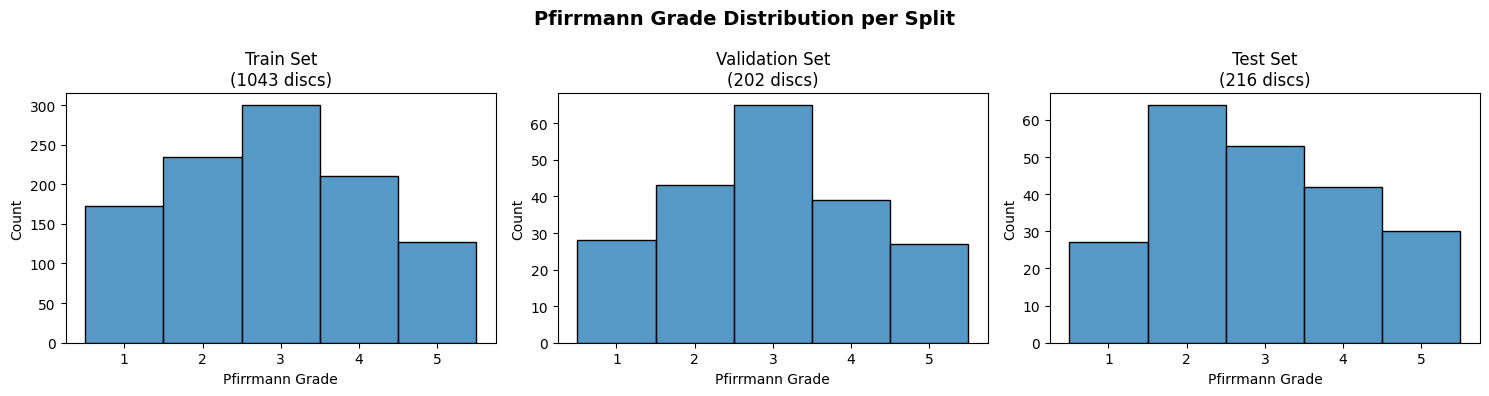

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, split_gradings) in zip(axes, [
    ("Train", train_gradings), 
    ("Validation", val_gradings), 
    ("Test", test_gradings)
]):
    sns.histplot(split_gradings.to_pandas(), x="Pfirrman grade", ax=ax, discrete=True)
    ax.set_title(f"{name} Set\n({len(split_gradings)} discs)")
    ax.set_xlabel("Pfirrmann Grade")
    ax.set_ylabel("Count")

plt.suptitle("Pfirrmann Grade Distribution per Split", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Dataset explanation:** <br>
samples: 447 sagittal T1 and T2 scans from 218 patients from 4 hospitals <br>
note: all patients have a history of low back pain

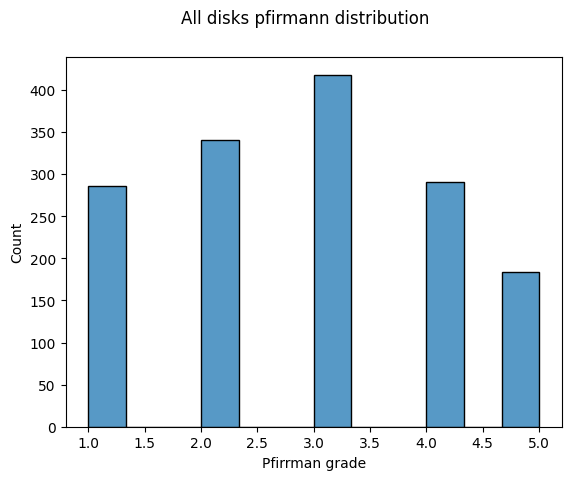

In [ ]:
fig, ax = plt.subplots()
sns.histplot(gradings, x='Pfirrman grade', ax=ax)
fig.suptitle("All disks pfirmann distribution")
plt.show()

In [7]:
(
    gradings
    .group_by("Patient")
    .agg(
        (pl.col('Pfirrman grade').max() >= 4).cast(pl.Int8).alias("has_pfirmann_4_or_more")
    )
    .group_by("has_pfirmann_4_or_more")
    .agg(
        pl.col("Patient").len().alias("patient_count")
    )
)

has_pfirmann_4_or_more,patient_count
i8,u32
0,69
1,149


**SpineNetv2 Intervertebral Disc Volume Extraction**

The approach follows SpineNet methodology:
1. Find oriented bounding box of each disc from the mask
2. Rotate the full scan so the disc is horizontal
3. Extract a region around the disc
4. Resize to fixed output shape (224×224×16)

In [8]:
# Load example scan and mask
image_path = images_path.joinpath("9_t2.mha")
mask_path = masks_path.joinpath("9_t2.mha")

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

print(f"Image shape: {sitk.GetArrayFromImage(image).shape}")
print(f"Mask shape: {sitk.GetArrayFromImage(mask).shape}")

Image shape: (610, 384, 19)
Mask shape: (610, 384, 19)


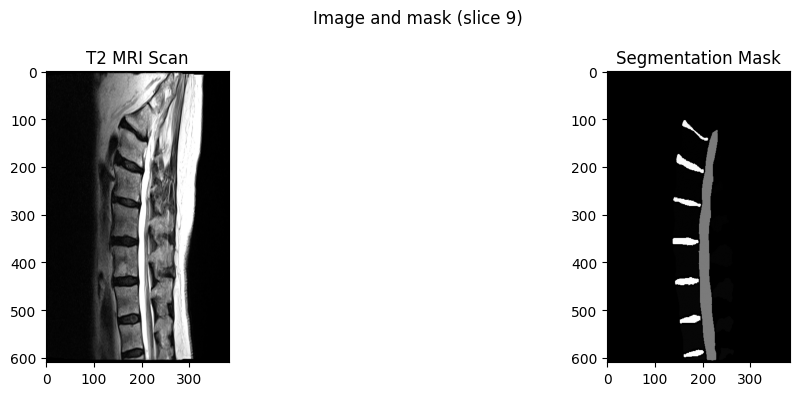

In [ ]:
image_arr = sitk.GetArrayFromImage(image)
mask_arr = sitk.GetArrayFromImage(mask)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].imshow(image_arr[:, :, 9], cmap='gray')
axes[0].set_title("T2 MRI Scan")
axes[1].imshow(mask_arr[:, :, 9], cmap='gray')
axes[1].set_title("Segmentation Mask")
fig.suptitle("Image and mask (slice 9)")
fig.tight_layout()
plt.show()

In [ ]:
def extract_disc_volumes(
    scan_sitk,
    mask_sitk,
    output_shape=(224, 224, 19),
    extent=1.0,
    resampling_mode="bicubic",
):
    """
    Extracts volumes surrounding each disc detected in the scan.
    
    Parameters
    ----------
    scan_sitk : The full MRI scan
    mask_sitk : Segmentation mask where disc labels are >= 200
    output_shape : Target output shape (H, W, D)
    extent : How much to expand the bounding box (1.0 = expand by edge_length on each side)
    
    Returns
    -------
    dict : {disc_label: volume_array}
    """
    scan_arr = sitk.GetArrayFromImage(scan_sitk).astype(np.float32)
    mask_arr = sitk.GetArrayFromImage(mask_sitk)
    
    print(f"Scan shape: {scan_arr.shape}")
    
    unique_labels = np.unique(mask_arr)
    disc_labels = unique_labels[unique_labels >= 200]
    
    processed_volumes = {}
    
    for label in disc_labels:
        label = int(label)
        print(f"Processing Disc {label}...")
        
        disc_mask = (mask_arr == label).astype(np.uint8)
        
        if np.sum(disc_mask) == 0:
            continue
        
        # Project mask to 2D (max projection across sagittal slices)
        mask_2d = np.max(disc_mask, axis=2).astype(np.uint8)
        
        contours, _ = cv2.findContours(mask_2d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print(f"  Warning: No contours found for disc {label}. Skipping.")
            continue
            
        contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(contour)
        
        try:
            volume = extract_single_volume(
                scan_arr, rect, extent=extent,
                output_shape=output_shape, resampling_mode=resampling_mode
            )
            processed_volumes[label] = volume
            print(f"  Successfully extracted volume with shape {volume.shape}")
        except Exception as e:
            print(f"  Error extracting disc {label}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return processed_volumes


def extract_single_volume(scan, rect, extent=1.0, output_shape=(224, 224, 19), resampling_mode="bicubic"):
    """
    Extract a single disc volume from the scan.
    
    Parameters
    ----------
    scan : np.array
        Shape (H, W, D) - the full MRI scan
    rect : tuple
        Output from cv2.minAreaRect: ((cx, cy), (w, h), angle)
    extent : float
        How much to expand around the disc
    output_shape : tuple
        Target output shape
    """
    center, (rect_w, rect_h), angle = rect
    cx, cy = center
    
    # Determine rotation angle to make disc horizontal
    # If rect_w < rect_h, the longer dimension is vertical, so rotate by angle+90
    rotation_angle = angle if rect_w >= rect_h else angle + 90
    
    # rotation matrix around disc center
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale=1)
    
    h_img, w_img, d = scan.shape
    
    rotated_scan = np.zeros_like(scan, dtype=np.float32)
    for i in range(d):
        rotated_scan[:, :, i] = cv2.warpAffine(
            scan[:, :, i], rotation_matrix, (w_img, h_img),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0
        )
    
    # Calculate crop region (disc is now axis-aligned after rotation)
    edge_len = max(rect_w, rect_h)  # Use longer dimension
    half_size = (1 + extent) * edge_len / 2
    
    x_min = int(cx - half_size)
    x_max = int(cx + half_size)
    y_min = int(cy - half_size)
    y_max = int(cy + half_size)
    
    # Handle boundary cases with padding
    pad_left = max(0, -x_min)
    pad_right = max(0, x_max - w_img)
    pad_top = max(0, -y_min)
    pad_bottom = max(0, y_max - h_img)
    
    if any([pad_left, pad_right, pad_top, pad_bottom]):
        rotated_scan = np.pad(
            rotated_scan,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode='constant', constant_values=0
        )
        x_min += pad_left
        x_max += pad_left
        y_min += pad_top
        y_max += pad_top
    
    # crop
    volume = rotated_scan[y_min:y_max, x_min:x_max, :]
    
    if volume.shape[0] == 0 or volume.shape[1] == 0:
        raise ValueError(f"Cropped volume has invalid shape: {volume.shape}")
    
    return resize_bb(volume, output_shape=output_shape, resampling_mode=resampling_mode).numpy()


def resize_bb(vol, output_shape=(224, 224, 19), resampling_mode="bicubic"):
    """
    Resize volume to output_shape using SpineNet's approach.
    vol: shape (H, W, D)
    """
    # Rearrange to (D, H, W) for batch processing, then add channel dim
    vol_tensor = torch.einsum("ijk->kij", torch.tensor(vol)).unsqueeze(1).type(torch.double)
    
    if resampling_mode in ["bicubic", "bilinear"]:
        new_vol = F.interpolate(
            vol_tensor, size=(output_shape[0], output_shape[1]),
            mode=resampling_mode, align_corners=False,
        ).squeeze(1)
    else:
        new_vol = F.interpolate(
            vol_tensor, size=(output_shape[0], output_shape[1]),
            mode=resampling_mode,
        ).squeeze(1)
    
    # Back to (H, W, D)
    new_vol = torch.einsum("kij->ijk", new_vol)
    
    # Interpolate depth using linear interpolation
    new_new_vol = torch.zeros(output_shape)
    ratio = float(new_vol.shape[-1]) / float(output_shape[-1])
    
    for i in range(output_shape[-1]):
        interp_val = i * ratio
        high_slice = int(np.ceil(interp_val))
        low_slice = int(np.floor(interp_val))
        
        if high_slice >= new_vol.shape[-1]:
            high_slice = new_vol.shape[-1] - 1
        if low_slice >= new_vol.shape[-1]:
            low_slice = new_vol.shape[-1] - 1
            
        if high_slice == low_slice:
            new_new_vol[:, :, i] = new_vol[:, :, high_slice]
        else:
            new_new_vol[:, :, i] = (
                new_vol[:, :, high_slice] * np.abs(low_slice - interp_val) + 
                new_vol[:, :, low_slice] * np.abs(high_slice - interp_val)
            )
    
    # Normalize using 95th percentile (SpineNet's method)
    arr_percentile = np.percentile(new_new_vol[:, :], 95)
    min_ = new_new_vol.min()
    for slice_ in range(new_new_vol.shape[-1]):
        new_new_vol[:, :, slice_] = (new_new_vol[:, :, slice_] - min_) / (arr_percentile + 0.000001)
    
    return new_new_vol

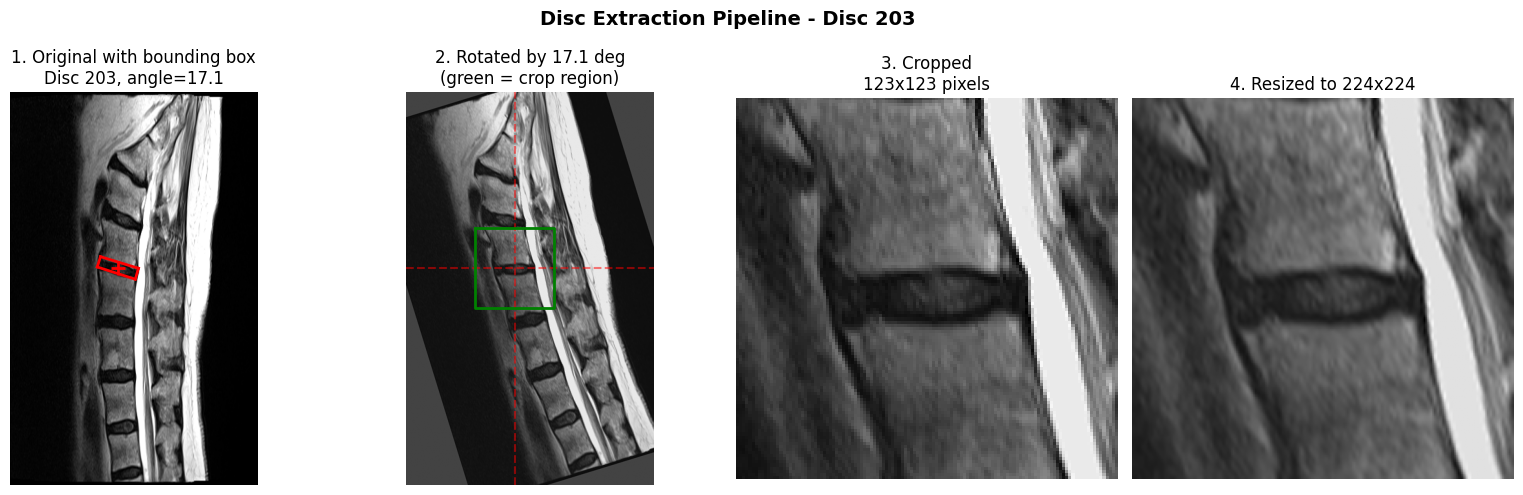

In [11]:
# Visualize the processing pipeline for a single disc
def visualize_extraction_pipeline(scan_sitk, mask_sitk, disc_label=203, extent=1.0, slice_idx=9):
    """
    Visualize the disc extraction processing steps:
    1. Original scan with oriented bounding box
    2. Rotated scan (disc straightened)
    3. Cropped region
    4. Final resized output
    """
    scan_arr = sitk.GetArrayFromImage(scan_sitk).astype(np.float32)
    mask_arr = sitk.GetArrayFromImage(mask_sitk)
    
    # Get disc mask and find bounding box
    disc_mask = (mask_arr == disc_label).astype(np.uint8)
    mask_2d = np.max(disc_mask, axis=2).astype(np.uint8)
    
    contours, _ = cv2.findContours(mask_2d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    
    center, (rect_w, rect_h), angle = rect
    cx, cy = center
    rotation_angle = angle if rect_w >= rect_h else angle + 90
    
    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale=1)
    
    h_img, w_img, d = scan_arr.shape
    
    # Get original slice
    original_slice = scan_arr[:, :, slice_idx]
    
    # Rotate slice
    rotated_slice = cv2.warpAffine(
        original_slice, rotation_matrix, (w_img, h_img),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0
    )
    
    # Calculate crop region
    edge_len = max(rect_w, rect_h)
    half_size = (1 + extent) * edge_len / 2
    
    x_min = int(cx - half_size)
    x_max = int(cx + half_size)
    y_min = int(cy - half_size)
    y_max = int(cy + half_size)
    
    # Safe crop boundaries
    x_min_safe = max(0, x_min)
    x_max_safe = min(w_img, x_max)
    y_min_safe = max(0, y_min)
    y_max_safe = min(h_img, y_max)
    
    cropped = rotated_slice[y_min_safe:y_max_safe, x_min_safe:x_max_safe]
    
    # Resize to final output
    resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_CUBIC)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    
    # 1. Original with bounding box
    axes[0].imshow(original_slice, cmap='gray')
    # Draw oriented bounding box
    for i in range(4):
        pt1 = tuple(box[i])
        pt2 = tuple(box[(i + 1) % 4])
        axes[0].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=2)
    axes[0].plot(cx, cy, 'r+', markersize=10, markeredgewidth=2)
    axes[0].set_title(f"1. Original with bounding box\nDisc {disc_label}, angle={angle:.1f}")
    axes[0].axis('off')
    
    # 2. Rotated scan
    axes[1].imshow(rotated_slice, cmap='gray')
    axes[1].axhline(y=cy, color='r', linestyle='--', alpha=0.5)
    axes[1].axvline(x=cx, color='r', linestyle='--', alpha=0.5)
    # Draw crop region
    axes[1].plot([x_min, x_max, x_max, x_min, x_min], 
                 [y_min, y_min, y_max, y_max, y_min], 'g-', linewidth=2)
    axes[1].set_title(f"2. Rotated by {rotation_angle:.1f} deg\n(green = crop region)")
    axes[1].axis('off')
    
    # 3. Cropped region
    axes[2].imshow(cropped, cmap='gray')
    axes[2].set_title(f"3. Cropped\n{cropped.shape[1]}x{cropped.shape[0]} pixels")
    axes[2].axis('off')
    
    # 4. Final resized output
    axes[3].imshow(resized, cmap='gray')
    axes[3].set_title(f"4. Resized to 224x224")
    axes[3].axis('off')
    
    plt.suptitle(f"Disc Extraction Pipeline - Disc {disc_label}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize for disc 203
visualize_extraction_pipeline(image, mask, disc_label=203, extent=1.0, slice_idx=9)

In [ ]:
# Use the FULL image and mask - NOT the masked versions!
# The function will extract regions from the full scan based on where discs are in the mask

processed_data = extract_disc_volumes(image, mask, output_shape=(224, 224, 19), extent=1.0)

print(f"\nSuccessfully processed {len(processed_data)} discs: {list(processed_data.keys())}")

Scan shape: (610, 384, 19)
Processing Disc 201...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 202...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 203...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 204...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 205...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 206...
  Successfully extracted volume with shape (224, 224, 16)
Processing Disc 207...
  Successfully extracted volume with shape (224, 224, 16)

Successfully processed 7 discs: [201, 202, 203, 204, 205, 206, 207]


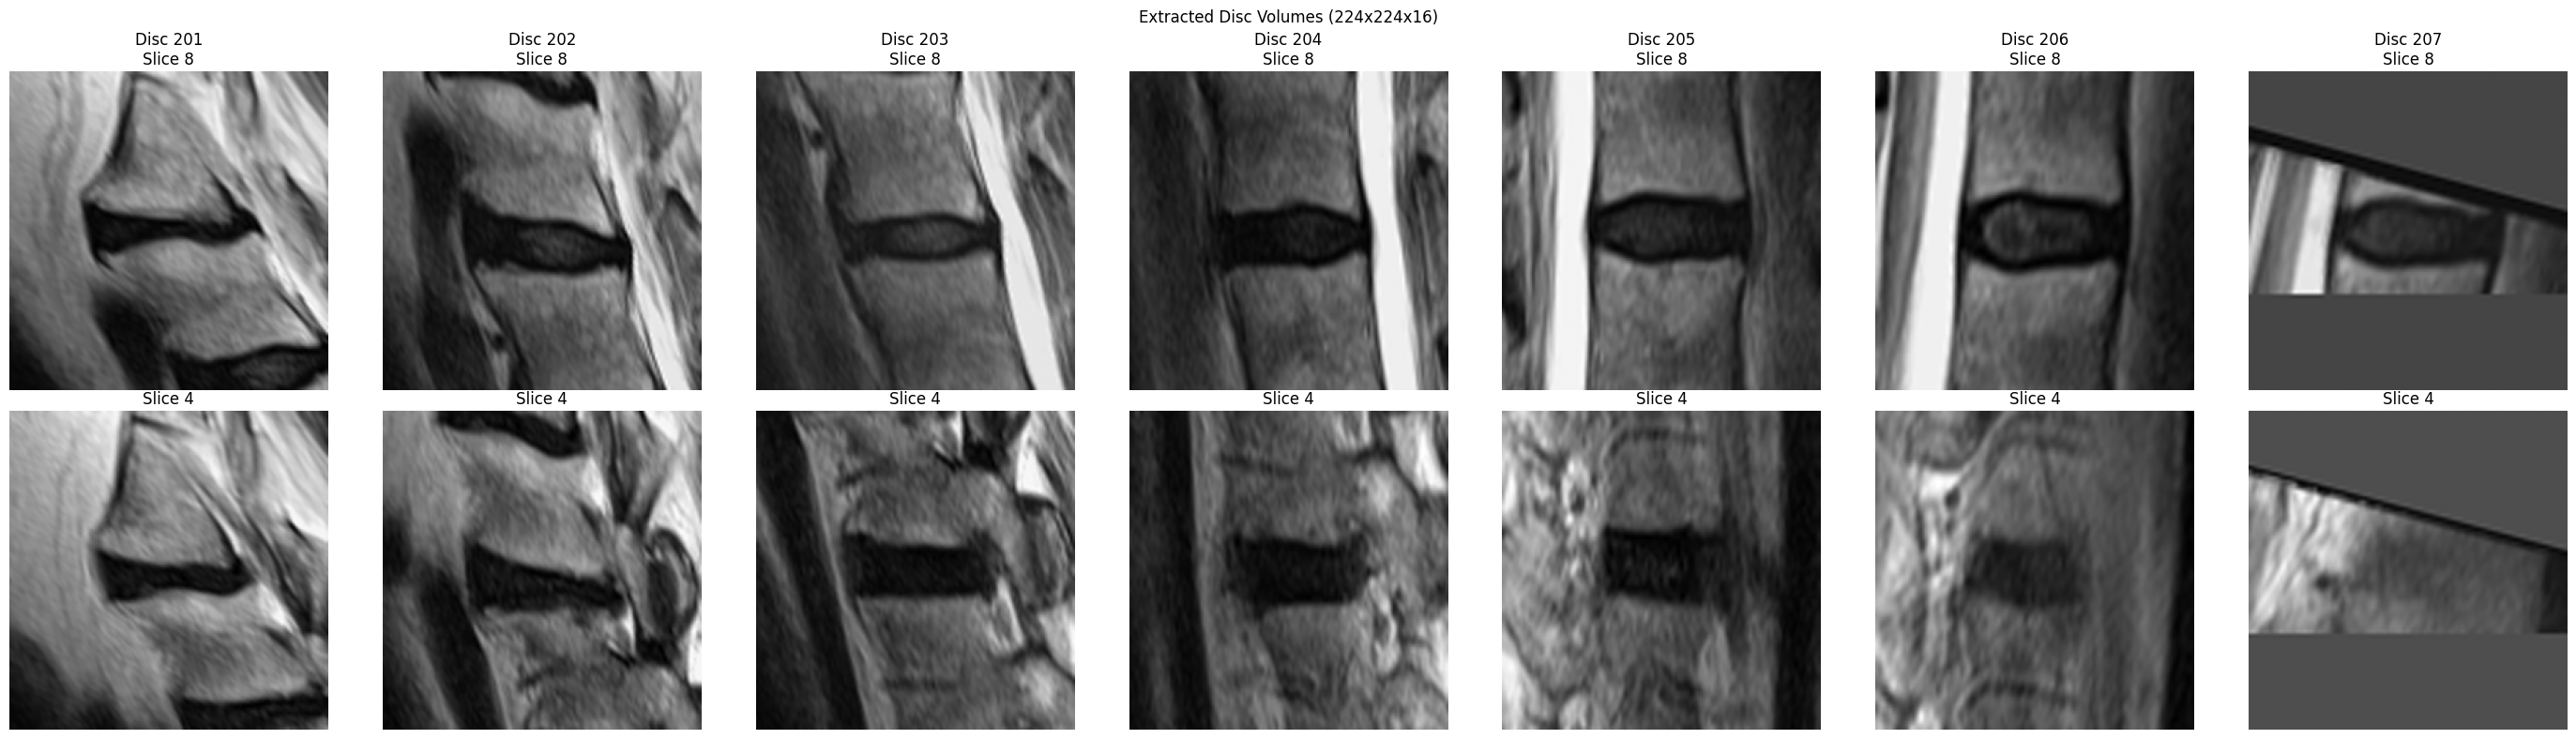

Disc 201: shape=(224, 224, 16), min=0.000, max=2.229, mean=0.924
Disc 202: shape=(224, 224, 16), min=0.000, max=2.072, mean=0.690
Disc 203: shape=(224, 224, 16), min=0.000, max=2.624, mean=0.773
Disc 204: shape=(224, 224, 16), min=0.000, max=3.004, mean=0.794
Disc 205: shape=(224, 224, 16), min=0.000, max=2.326, mean=0.680
Disc 206: shape=(224, 224, 16), min=0.000, max=2.095, mean=0.680
Disc 207: shape=(224, 224, 16), min=0.000, max=3.753, mean=1.051


In [13]:
# Visualize the extracted volumes
fig, axes = plt.subplots(2, len(processed_data), figsize=(4*len(processed_data), 8))

for idx, (label, vol) in enumerate(processed_data.items()):
    # Show middle slice
    mid_slice = vol.shape[2] // 2
    axes[0, idx].imshow(vol[:, :, mid_slice], cmap='gray')
    axes[0, idx].set_title(f"Disc {label}\nSlice {mid_slice}")
    axes[0, idx].axis('off')
    
    # Show a different slice
    other_slice = vol.shape[2] // 4
    axes[1, idx].imshow(vol[:, :, other_slice], cmap='gray')
    axes[1, idx].set_title(f"Slice {other_slice}")
    axes[1, idx].axis('off')

plt.suptitle("Extracted Disc Volumes (224x224x16)")
plt.tight_layout()
plt.show()

# Print volume statistics
for label, vol in processed_data.items():
    print(f"Disc {label}: shape={vol.shape}, min={vol.min():.3f}, max={vol.max():.3f}, mean={vol.mean():.3f}")

---
## 3D CNN Model for Pfirrmann Grade Classification

SpineNetv2-style 3D ResNet for classifying intervertebral disc degeneration.

In [14]:
# 3D CNN building blocks (SpineNetv2 style)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(
        in_planes,
        out_planes,
        (3, 3, 3),
        stride=(1, stride, stride),
        padding=(1, dilation, dilation),
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(
        in_planes,
        out_planes,
        (1, 1, 1),
        stride=(1, stride, stride),
        padding=(0, 0, 0),
        bias=False,
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        width = int(planes * (base_width / 64.0)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [15]:
class PfirrmannGradingModel(nn.Module):
    """
    3D ResNet for Pfirrmann grade classification.
    Simplified version of SpineNetv2 GradingModel - only outputs Pfirrmann grade (5 classes).
    """
    def __init__(
        self,
        block=BasicBlock,
        layers: List[int] = [3, 4, 6, 3],
        num_classes: int = 5,  # Pfirrmann grades 1-5
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group=64,
        norm_layer=None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        replace_stride_with_dilation = [False, False, False]
        self.groups = groups
        self.base_width = width_per_group
        
        # Initial convolution
        self.conv1 = nn.Conv3d(
            1, self.inplanes, (3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d((1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=1, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, D, H, W) - batch, channel, depth, height, width
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Test model instantiation
model = PfirrmannGradingModel(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=5)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# Test forward pass with dummy input (B, C, D, H, W)
dummy_input = torch.randn(2, 1, 16, 224, 224)
output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}  (batch_size, num_classes)")

Model created with 33,150,085 parameters
Input shape: torch.Size([2, 1, 16, 224, 224])
Output shape: torch.Size([2, 5])  (batch_size, num_classes)


In [ ]:
class DiscDataset(Dataset):
    """
    Dataset for loading disc volumes and their Pfirrmann grades.
    Extracts discs on-the-fly from MRI scans.
    """
    def __init__(
        self, 
        file_pairs: List[dict], 
        gradings_df: pl.DataFrame,
        output_shape: Tuple[int, int, int] = (224, 224, 19),
        extent: float = 1.0,
        transform=None,
        cache_volumes: bool = False,
    ):
        self.file_pairs = file_pairs
        self.output_shape = output_shape
        self.extent = extent
        self.transform = transform
        self.cache_volumes = cache_volumes
        self._cache = {}
        
        # Build index: list of (file_pair_idx, disc_label, pfirrmann_grade)
        self.samples = []
        
        for fp_idx, fp in enumerate(file_pairs):
            patient_id = fp["patient_id"]
            patient_gradings = gradings_df.filter(pl.col("Patient") == patient_id)
            
            for row in patient_gradings.iter_rows(named=True):
                ivd_label = row["IVD label"]
                disc_label = DISC_LABEL_MAPPING.get(ivd_label)
                pfirrmann_grade = row["Pfirrman grade"]
                
                if disc_label is not None and pfirrmann_grade is not None:
                    self.samples.append({
                        "file_pair_idx": fp_idx,
                        "disc_label": disc_label,
                        "pfirrmann_grade": int(pfirrmann_grade) - 1,  # 0-indexed (0-4)
                        "patient_id": patient_id,
                    })
        
        print(f"Dataset created with {len(self.samples)} disc samples from {len(file_pairs)} scans")
    
    def __len__(self):
        return len(self.samples)
    
    def _extract_disc(self, scan_sitk, mask_sitk, disc_label):
        """Extract a single disc volume from scan."""
        scan_arr = sitk.GetArrayFromImage(scan_sitk).astype(np.float32)
        mask_arr = sitk.GetArrayFromImage(mask_sitk)
        
        disc_mask = (mask_arr == disc_label).astype(np.uint8)
        if np.sum(disc_mask) == 0:
            return None
        
        mask_2d = np.max(disc_mask, axis=2).astype(np.uint8)
        contours, _ = cv2.findContours(mask_2d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return None
        
        contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(contour)
        
        try:
            volume = extract_single_volume(
                scan_arr, rect, extent=self.extent,
                output_shape=self.output_shape, resampling_mode="bicubic"
            )
            return volume
        except Exception:
            return None
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        fp_idx = sample["file_pair_idx"]
        disc_label = sample["disc_label"]
        
        cache_key = (fp_idx, disc_label)
        
        if self.cache_volumes and cache_key in self._cache:
            volume = self._cache[cache_key]
        else:
            fp = self.file_pairs[fp_idx]
            scan_sitk = sitk.ReadImage(str(fp["image_path"]))
            mask_sitk = sitk.ReadImage(str(fp["mask_path"]))
            
            volume = self._extract_disc(scan_sitk, mask_sitk, disc_label)
            
            if volume is None:
                # Return zeros if extraction fails
                volume = np.zeros(self.output_shape, dtype=np.float32)
            
            if self.cache_volumes:
                self._cache[cache_key] = volume
        
        # (H, W, D) to (1, D, H, W)
        volume_tensor = torch.from_numpy(volume).float()
        volume_tensor = volume_tensor.permute(2, 0, 1).unsqueeze(0)  # (1, D, H, W)
        
        if self.transform:
            volume_tensor = self.transform(volume_tensor)
        
        label = torch.tensor(sample["pfirrmann_grade"], dtype=torch.long)
        
        return volume_tensor, label


train_dataset = DiscDataset(train_files, gradings, cache_volumes=False)
val_dataset = DiscDataset(val_files, gradings, cache_volumes=False)
test_dataset = DiscDataset(test_files, gradings, cache_volumes=False)

Creating datasets...
Dataset created with 986 disc samples from 147 scans
Dataset created with 200 disc samples from 31 scans
Dataset created with 210 disc samples from 32 scans


In [ ]:
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: cuda
Train batches: 124
Val batches: 25
Test batches: 27


In [18]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (volumes, labels) in enumerate(loader):
        volumes = volumes.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(volumes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if (batch_idx + 1) % 20 == 0:
            print(f"  Batch {batch_idx + 1}/{len(loader)}, Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate model on a dataset."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for volumes, labels in loader:
            volumes = volumes.to(device)
            labels = labels.to(device)
            
            outputs = model(volumes)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

In [ ]:
model = PfirrmannGradingModel(
    block=BasicBlock,
    layers=[2, 2, 2, 2],
    num_classes=5
).to(DEVICE)

# class weights because our dataset is unbalanced
class_counts = np.bincount([s["pfirrmann_grade"] for s in train_dataset.samples], minlength=5)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print(f"Class counts in training set: {class_counts}")
print(f"Class weights: {class_weights.cpu().numpy()}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Class counts in training set: [154 221 289 199 123]
Class weights: [1.1749207 0.818723  0.6260823 0.9092351 1.4710389]


In [ ]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
best_model_state = None

print("Starting training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  New best model! Val Acc: {val_acc:.2f}%")

print("\n" + "=" * 60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/50


/tmp/ipykernel_25407/3159493551.py:18: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  running_loss += loss.item()


  Batch 20/124, Loss: 1.8066
  Batch 40/124, Loss: 1.3871
  Batch 60/124, Loss: 1.6371
  Batch 80/124, Loss: 1.7593
  Batch 100/124, Loss: 1.3665
  Batch 120/124, Loss: 1.6468
  Train Loss: 1.5989, Train Acc: 25.66%
  Val Loss: 1.5088, Val Acc: 22.50%
  New best model! Val Acc: 22.50%

Epoch 2/50
  Batch 20/124, Loss: 1.3691
  Batch 40/124, Loss: 1.3164
  Batch 60/124, Loss: 1.4720
  Batch 80/124, Loss: 1.3220
  Batch 100/124, Loss: 1.3284
  Batch 120/124, Loss: 1.1885
  Train Loss: 1.4591, Train Acc: 28.90%
  Val Loss: 1.4057, Val Acc: 31.50%
  New best model! Val Acc: 31.50%

Epoch 3/50
  Batch 20/124, Loss: 1.6768
  Batch 40/124, Loss: 1.4739
  Batch 60/124, Loss: 1.0620
  Batch 80/124, Loss: 1.2362
  Batch 100/124, Loss: 1.1316
  Batch 120/124, Loss: 1.2585
  Train Loss: 1.3939, Train Acc: 34.79%
  Val Loss: 1.7377, Val Acc: 23.00%

Epoch 4/50
  Batch 20/124, Loss: 1.2824
  Batch 40/124, Loss: 1.1478
  Batch 60/124, Loss: 1.5244
  Batch 80/124, Loss: 1.6161
  Batch 100/124, Loss: 1

KeyboardInterrupt: 

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc')
axes[1].plot(val_accs, label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on test set with best model
from sklearn.metrics import classification_report, confusion_matrix

if best_model_state is not None:
    model.load_state_dict(best_model_state)

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print()

# Classification report
print("Classification Report:")
print(classification_report(
    test_labels, test_preds,
    target_names=[f"Grade {i+1}" for i in range(5)],
    zero_division=0
))

Test Loss: 1.1287
Test Accuracy: 48.10%

Classification Report:
              precision    recall  f1-score   support

     Grade 1       0.47      0.63      0.54        27
     Grade 2       0.48      0.62      0.54        63
     Grade 3       0.48      0.40      0.44        52
     Grade 4       0.50      0.13      0.21        38
     Grade 5       0.50      0.63      0.56        30

    accuracy                           0.48       210
   macro avg       0.49      0.48      0.46       210
weighted avg       0.48      0.48      0.46       210



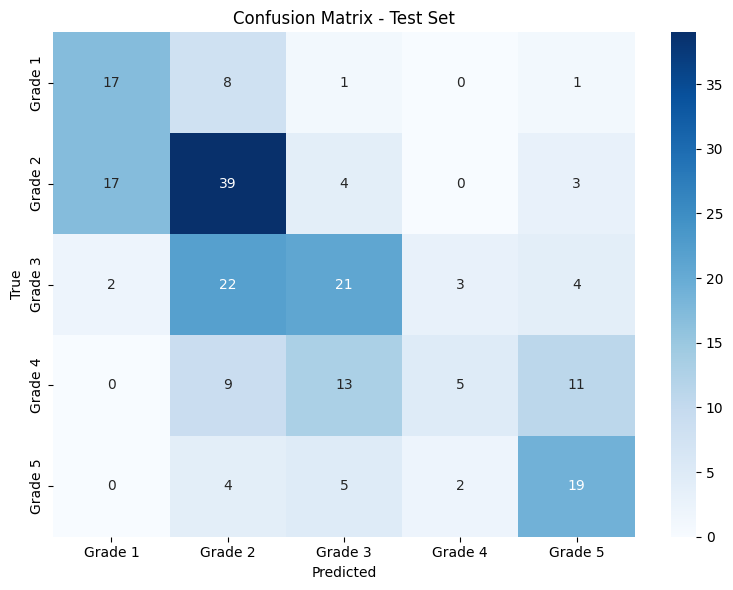

In [22]:
# Confusion matrix visualization
cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f"Grade {i+1}" for i in range(5)],
    yticklabels=[f"Grade {i+1}" for i in range(5)],
    ax=ax
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [23]:
# Save the trained model
model_save_path = project_path / "SpineNetv2" / "pfirrmann_model.pth"
torch.save({
    'model_state_dict': best_model_state if best_model_state is not None else model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'best_val_acc': best_val_acc,
    'test_acc': test_acc,
    'class_weights': class_weights.cpu().numpy(),
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /home/mpuscian/Desktop/repozytoria/MINI_projects/Intervertebral-discs-degeneration-grade-classification-according-to-the-Pfirrmann-scale/SpineNetv2/pfirrmann_model.pth
